In [1]:
import logging
import random
import re
import time
from collections import Counter
from collections.abc import Sequence, Iterable
from pathlib import Path
from typing import Literal, Any
from itertools import groupby
import matplotlib.pyplot as plt

import polars as pl
import requests
import pickle
from tqdm.auto import tqdm

In [2]:
logging.basicConfig(
    format="%(levelname)s: %(message)s",
    level=logging.INFO,
    force=True
)

PATH_RAW = Path("../data/raw")
PATH_MONTHLY = Path("../data/monthly")
YELLOW_PATH_PATTERN = "yellow_tripdata*.parquet"


def get_progress_bar(
        data: Iterable,
        desc: str | None = None,
        unit: str | None = None,
        colour: str | None = None,
        leave: bool | None = None,
        position: int | None = None
) -> tqdm:
    """
    Create a tqdm progress bar with optional parameters.

    :param data: Iterable to iterate over.
    :param desc: Description text displayed before the bar.
    :param unit: Unit of iteration (e.g., 'files', 'rows').
    :param colour: Colour of the progress bar.
    :param leave: Whether to leave the bar after completion.
    :param position: Position index for multiple bars.
    :return: Configured tqdm progress bar.
    """

    opts = {k: v for k, v in {
        "desc": desc, "unit": unit, "colour": colour,
        "leave": leave, "position": position
    }.items() if v is not None}

    return tqdm(data, **opts)


def get_dates(
        years: Sequence[int | str] | None = None,
        months: Sequence[int | str] | None = None
) -> list[tuple[str, str]]:
    """
    Generate all (year, month) combinations.

    :param years: Sequence of years (e.g., ``["2020", "2021"]``). Defaults to 2011–2025.
    :param months: Sequence of months in ``"MM"`` format. Defaults to 01–12.
    :return: List of (year, month) tuples.
    """
    years = years or range(2011, 2025)
    months = months or range(1, 13)

    years_str = [f"{int(y):04d}" for y in years]
    months_str = [f"{int(m):02d}" for m in months]

    return [(year, month) for year in years_str for month in months_str]

# EDA NYC TLC

## Descarga de los datos

In [3]:
def print_summary(
        total_downloads: int,
        files_already_downloaded: int,
        errors: list[tuple[str, str]],
        check: bool = False
) -> None:
    """
    Print a summary of the download process.

    :param total_downloads: Number of files successfully downloaded.
    :param files_already_downloaded: Number of files skipped because they already existed.
    :param errors: List of (url, error) tuples for failed downloads.
    :param check: If True, some downloads may have been skipped due to existing files.
    """
    msg = ["\n📥 Download summary:"]
    if check:
        msg.append(f"\t📂 Files already existed: {files_already_downloaded}")
    msg.append(f"\t✅ Files downloaded: {total_downloads}")

    logging.info("\n".join(msg))

    if errors:
        err_msg = [
            f"\n⚠️ Errors in {len(errors)} downloads (showing up to 5):"]
        err_msg += [f"  - {url} → {err}" for url, err in errors[:5]]
        logging.warning("\n".join(err_msg))


def download_nyc_taxi(
        years: Sequence[str] | None = None,
        months: Sequence[str] | None = None,
        check: bool = False
) -> None:
    """
    Download NYC yellow taxi trip data in Parquet format.

    :param years: Sequence of years (e.g., ``["2020", "2021"]``). Defaults to 2011–2025.
    :param months: Sequence of months in ``"MM"`` format. Defaults to 01–12.
    :param check: If True, skip downloads for files that already exist.
    """
    dates = get_dates(years, months)
    total, skipped, errors = 0, 0, []

    progress = get_progress_bar(dates, desc="📂 Downloading files", unit="file")

    for year, month in progress:
        path = Path(PATH_RAW) / f"yellow_tripdata_{year}-{month}.parquet"
        if check and path.exists():
            skipped += 1
            continue

        path.parent.mkdir(parents=True, exist_ok=True)
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{path.name}"

        try:
            with requests.get(url, stream=True, timeout=60) as r:
                r.raise_for_status()
                with open(path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            total += 1
        except requests.exceptions.RequestException as e:
            errors.append((url, str(e)))

        # Random wait to avoid hammering the server
        time.sleep(random.uniform(1, 3))

    print_summary(total, skipped, errors, check)

In [5]:
download_nyc_taxi(check=True)

📂 Downloading files:   0%|          | 0/168 [00:00<?, ?file/s]

INFO: 
📥 Download summary:
	📂 Files already existed: 0
	✅ Files downloaded: 168


## Inspección de datos

### Diccionario de Variables – Yellow Taxi TLC


- **VendorID**
  Código que indica el proveedor TPEP que proporcionó el registro.
  - 1 = Creative Mobile Technologies, LLC
  - 2 = Curb Mobility, LLC
  - 6 = Myle Technologies Inc
  - 7 = Helix

- **tpep_pickup_datetime**
  Fecha y hora en que se activó el taxímetro.

- **tpep_dropoff_datetime**
  Fecha y hora en que se desactivó el taxímetro.

- **passenger_count**
  Número de pasajeros en el vehículo.

- **trip_distance**
  Distancia recorrida del viaje en millas reportada por el taxímetro.

- **RatecodeID**
  Código de tarifa final en vigor al final del viaje.
  - 1 = Tarifa estándar
  - 2 = JFK
  - 3 = Newark
  - 4 = Nassau o Westchester
  - 5 = Tarifa negociada
  - 6 = Viaje en grupo
  - 99 = Nulo/desconocido

- **store_and_fwd_flag**
  Indicador de sí el registro de viaje se guardó en la memoria del vehículo antes de enviarse al proveedor (“almacenar y reenviar”), debido a que no había conexión al servidor.
  - Y = viaje almacenado y reenviado
  - N = viaje no almacenado y reenviado

- **PULocationID**
  Zona TLC donde se activó el taxímetro.

- **DOLocationID**
  Zona TLC donde se desactivó el taxímetro.

- **payment_type**
  Código numérico que indica cómo pagó el pasajero el viaje.
  - 0 = Viaje Flex Fare
  - 1 = Tarjeta de crédito
  - 2 = Efectivo
  - 3 = Sin cargo
  - 4 = Disputa
  - 5 = Desconocido
  - 6 = Viaje anulado

- **fare_amount**
  Tarifa calculada por tiempo y distancia según el taxímetro.

- **extra**
  Extras y recargos misceláneos.

- **mta_tax**
  Impuesto activado automáticamente según la tarifa en uso.

- **tip_amount**
  Monto de la propina. Este campo se completa automáticamente para pagos con tarjeta de crédito (las propinas en efectivo no se incluyen).

- **tolls_amount**
  Total de peajes pagados en el viaje.

- **improvement_surcharge**
  Recargo por mejora aplicado al inicio del viaje (implementado en 2015).

- **total_amount**
  Importe total cobrado a los pasajeros (no incluye propinas en efectivo).

- **congestion_surcharge**
  Monto total recaudado en el viaje por el recargo de congestión del Estado de Nueva York.

- **airport_fee**
  Cargo por recogida en los aeropuertos LaGuardia y John F. Kennedy.

- **cbd_congestion_fee**
  Cargo por viaje en la Zona de Alivio de Congestión del MTA a partir del 5 de enero de 2025.

### Comprobación tamaño de los ficheros

In [15]:
def fmt_size(mb: float) -> str:
    """
    Format a numeric size dynamically in MB or GB.

    :param mb: File size in megabytes (MB).
    :return: Formatted size as a string, using MB if below 1024 or GB otherwise.
    """
    return f"{mb / 1024:.2f} GB" if mb >= 1024 else f"{mb:.2f} MB"


def check_files_size(
        path: Path | str,
        pattern: str = "yellow_tripdata_*.parquet",
        count_limit: int = 3,
        size_limit: int = 10
) -> None:
    """
    Generate a summary of the number and size of the Parquet files in a directory.

    :param path: Directory path or string containing files.
    :param pattern: Glob pattern for files. Defaults to ``"yellow_tripdata_*.parquet"``.
    :param count_limit: Maximum number of file names to display. Defaults to 3.
    :param size_limit: Maximum number of files to display with size information. Defaults to 10.
    :return: None
    """
    path = Path(path)
    files = sorted(path.glob(pattern))
    msg = [f"🧾 Total number of files: {len(files)}"]

    # File listing (limited)
    listed = [f"📂 {f.name}" for f in files[:count_limit]]
    if len(files) > count_limit:
        listed.append("...")
    msg.append("  " + "\n  ".join(listed))

    if files:
        # Calculate sizes in MB
        sizes = [f.stat().st_size / 1e6 for f in files]
        total, min_s, mean_s, max_s = (
            sum(sizes), min(sizes), sum(sizes) / len(sizes), max(sizes)
        )

        stats = (
            f"📏 Sizes → TOTAL: {fmt_size(total)} | Min: {fmt_size(min_s)} | "
            f"Mean: {fmt_size(mean_s)} | Max: {fmt_size(max_s)}"
        )

        # Detailed file sizes (limited)
        sized = [
            f"📂 {f.name} — {fmt_size(f.stat().st_size / 1e6)}"
            for f in files[:size_limit]
        ]
        if len(files) > size_limit:
            sized.append("...")
        msg.append(stats + "\n  " + "\n  ".join(sized))

    logging.info("\n" + "\n".join(msg))

In [16]:
check_files_size(PATH_RAW)

INFO: 
🧾 Total number of files: 168
  📂 yellow_tripdata_2011-01.parquet
  📂 yellow_tripdata_2011-02.parquet
  📂 yellow_tripdata_2011-03.parquet
  ...
📏 Sizes → TOTAL: 19.18 GB | Min: 4.44 MB | Mean: 116.93 MB | Max: 204.98 MB
  📂 yellow_tripdata_2011-01.parquet — 167.18 MB
  📂 yellow_tripdata_2011-02.parquet — 175.98 MB
  📂 yellow_tripdata_2011-03.parquet — 199.93 MB
  📂 yellow_tripdata_2011-04.parquet — 184.20 MB
  📂 yellow_tripdata_2011-05.parquet — 193.43 MB
  📂 yellow_tripdata_2011-06.parquet — 189.12 MB
  📂 yellow_tripdata_2011-07.parquet — 184.03 MB
  📂 yellow_tripdata_2011-08.parquet — 166.21 MB
  📂 yellow_tripdata_2011-09.parquet — 183.49 MB
  📂 yellow_tripdata_2011-10.parquet — 196.27 MB
  ...


### Comprobación Nombre de Variables

Como *improvement_surcharge* se implantó en 2015 y *cbd_congestion_fee* se implantó en 2025, crearemos dos listas de variables. Una lista con las variables obligatorias y otra con las variables opcionales que no comparten todos los archivos.

In [17]:
# Required columns (present every year since 2011)
REQUIRED_COLS = [
    "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "passenger_count", "trip_distance", "RatecodeID", "store_and_fwd_flag",
    "PULocationID", "DOLocationID", "payment_type", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount", "total_amount",
    "congestion_surcharge", "airport_fee"
]

# Optional columns (added in subsequent years)
OPTIONAL_COLS = [
    "improvement_surcharge",  # since 2015
    "cbd_congestion_fee"  # since 2025
]

In [18]:
def normalize_column_names(lf: pl.LazyFrame) -> pl.LazyFrame:
    """
    Normalize column names: lowercase and replace spaces with underscores.

    :param lf: LazyFrame whose column names will be normalized.
    :return: LazyFrame with all column names normalized.
    """
    return lf.rename({
        c: c.strip().lower().replace(" ", "_")
        for c in lf.collect_schema().names()
    })


def check_schema_variations(
        path: Path | str,
        required_cols: Sequence[str],
        optional_cols: Sequence[str] | None = None,
        pattern: str = "yellow_tripdata_*.parquet"
) -> None:
    """
    Inspect Parquet files in a directory, check their schema, and detect missing or inconsistent columns.

    :param path: Path or string pointing to the directory containing the files.
    :param required_cols: List of required column names.
    :param optional_cols: Optional list of column names to check (perhaps missing in older files).
    :param pattern: File search pattern. Defaults to ``"yellow_tripdata_*.parquet"``.
    :return: None
    """
    # --- Logging setup ---
    logger = logging.getLogger("check_schema")
    if not logger.handlers:
        handler = logging.StreamHandler()
        handler.setFormatter(logging.Formatter("%(levelname)s - %(message)s"))
        logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    logger.propagate = False

    # --- File collection ---
    path = Path(path)
    files = sorted(path.glob(pattern))
    print(f"🔎 Found {len(files)} file(s) to inspect.")

    # --- Containers for results ---
    required_issues, optional_issues, bad_files = [], [], []

    # -- Main loop ---
    for file in files:
        try:
            lf = normalize_column_names(pl.scan_parquet(file))
            schema = [c for c in lf.collect_schema().names()]

            missing_required = (
                [c for c in required_cols if c.lower() not in schema]

            )
            missing_optional = (
                [c for c in optional_cols if c.lower() not in schema]
                if optional_cols else []
            )

            if missing_required:
                required_issues.append((file, missing_required))
            if missing_optional:
                optional_issues.append((file, missing_optional))

        except Exception as e:
            bad_files.append((file, [f"Error: {e}"]))

    # --- Logging summary ---
    if not required_issues:
        print("✅ All files contain the required columns.")
    else:
        logger.warning(
            f"\n❌ {len(required_issues)} file(s) missing required columns:\n"
            + "\n".join(
                f"  📂 {f.name}: {missing}" for f, missing in required_issues)
        )

    if optional_cols:
        if not optional_issues:
            print(
                "✅ All files contain the optional columns (if expected)."
            )
        else:
            logger.warning(
                (f"\n⚠️ {len(optional_issues)} file(s) missing optional "
                 "columns:\n" + "\n".join(
                    f"  📂 {f.name}: {missing}"
                    for f, missing in optional_issues
                )
                 )
            )

    if bad_files:
        logger.error(
            f"\n🚫 {len(bad_files)} file(s) failed to load:\n"
            + "\n".join(f"  📂 {f.name}: {err}" for f, err in bad_files)
        )

In [19]:
check_schema_variations(PATH_RAW, REQUIRED_COLS, OPTIONAL_COLS)

🔎 Found 168 file(s) to inspect.


WARNING - 
⚠️ 168 file(s) missing optional columns:
  📂 yellow_tripdata_2011-01.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-02.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-03.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-04.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-05.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-06.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-07.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-08.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-09.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-10.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-11.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2011-12.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2012-01.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2012-02.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2012-03.parquet: ['cbd_congestion_fee']
  📂 yellow_tripdata_2012-04.parquet: ['cbd_conge

✅ All files contain the required columns.


Como *cbd_congestion_fee* se implantó en 2025 tiene sentido que no exista en ningún archivo, aunque la variable *improvement_surcharge* si aparece en todos los años, presumiblemente contendrán valores nulos.

### Comprobación registros fuera de rango de fecha

Ahora vamos a comprobar si hay registros cuya fecha de recogida no coincide con el mes y el año en el que están guardados y si el día de recogida es posterior al día de entrega.

In [20]:
def validate_date_ranges(
        directory: Path | str,
        pick_up: str = "tpep_pickup_datetime",
        drop_off: str = "tpep_dropoff_datetime",
        years: Iterable[int] | None = range(2011, 2025),
        months: Iterable[int] | None = range(1, 13),
        engine: Literal["auto", "in-memory", "streaming", "gpu"] = "streaming"
) -> tuple[dict[int, dict[int, dict[str, float]]], float]:
    """
    Validate pickup and dropoff datetime ranges in monthly taxi data files.

    Each file is checked to identify rows where pickup/dropoff dates fall
    outside the expected year-month range or where pickup occurs after dropoff.

    :param directory: Directory containing the monthly parquet files.
    :param pick_up: Name of the pickup datetime column.
    :param drop_off: Name of the dropoff datetime column.
    :param years: Iterable of years to check.
    :param months: Iterable of months to check.
    :param engine: Polars execution engine (default: ``"streaming"``).
    :return: Tuple containing:
            - A dictionary of outlier counts and percentages per year-month.
            - The maximum outlier percentage across all months.
    """
    directory = Path(directory)
    dates = get_dates(years, months)
    progress = get_progress_bar(dates, desc="Checking dates")

    date_outliers = {
        year: {m: 0 for _, m in group}
        for year, group in groupby(dates, key=lambda x: x[0])
    }
    max_pct = 0.0

    for year, month in progress:
        file_path = directory / f"yellow_tripdata_{year}-{month}.parquet"
        lf = pl.scan_parquet(file_path)

        filters = [
            (pl.col(pick_up).dt.month() != int(month))
            | (pl.col(pick_up).dt.year() != int(year))
            | ~(
                pl.col(drop_off).dt.month().is_between(int(month),
                                                       int(month) + 1,
                                                       closed="both")
            )
            | ~(
                pl.col(drop_off).dt.year().is_between(int(year),
                                                      int(year) + 1,
                                                      closed="both")
            )
            | (pl.col(pick_up) > pl.col(drop_off))
        ]

        n_outliers = (
            lf.filter(filters).select(pl.len()).collect(engine=engine).item()
        )
        total_rows = lf.select(pl.len()).collect(engine=engine).item()
        pct_outliers = (
            round((n_outliers / total_rows * 100), 2)
            if total_rows > 0 else 0.0
        )

        max_pct = max(max_pct, pct_outliers)

        date_outliers[year][month] = {
            "count": n_outliers,
            "pct": pct_outliers
        }

    print(f"The maximum percentage of outliers is: {max_pct:.2f} %")

    return date_outliers, max_pct


def summarize_date_outliers(
        date_outliers: dict[int, dict[int, dict[str, float]]],
        threshold: float = 5.0,
        limit: int = 5,
) -> None:
    """
    Display a summary table of outlier statistics by year and month.

    Highlights:
        - Total number and percentage of outliers.
        - Month with the highest number of outliers.
        - Month with the highest outlier percentage.
        - Months exceeding the given percentage threshold.

    :param date_outliers: Output dictionary from :func:`validate_date_ranges`.
    :param threshold: Threshold percentage to highlight (default: ``5.0``).
    :param limit: Maximum number of outliers per month printed.
    :return: None
    """
    # --- Prepare rows and track maxima
    rows = []
    max_count = ("", "", 0)
    max_pct = ("", "", 0.0)

    for year, months in sorted(date_outliers.items()):
        for month, data in sorted(months.items()):
            count_outliers, pct = data["count"], data["pct"]
            rows.append((year, month, count_outliers, pct))
            if count_outliers > max_count[2]:
                max_count = (year, month, count_outliers)
            if pct > max_pct[2]:
                max_pct = (year, month, pct)

    if not rows:
        print("⚠️ No data found.")
        return

    # --- Print formatted table
    print("\n📊 Outlier Summary by Month")
    print("-" * 50)
    print(f"{'Year':<8}{'Month':<8}{'Outliers':>12}{'% Outliers':>15}")
    print("-" * 50)
    for i, (year, month, count_outliers, pct) in enumerate(rows):
        if i > limit:
            print("...")
            break
        print(f"{year:<8}{month:<8}{count_outliers:>12,.0f}{pct:>15.2f}")
    print("-" * 50)

    # --- Summary metrics
    print("\n🏆 Highlights")
    print(
        f"  • Highest count : {max_count[2]:,.0f} → {max_count[0]}-{max_count[1]}")
    print(
        f"  • Highest %     : {max_pct[2]:.2f}% → {max_pct[0]}-{max_pct[1]}")

    # --- Months exceeding threshold
    high_outliers = [
        (y, m, d["count"], d["pct"])
        for y, months in date_outliers.items()
        for m, d in months.items()
        if d["pct"] > threshold
    ]

    if high_outliers:
        print(f"\n🚨 Months exceeding {threshold:.2f}% of outliers:")
        print("-" * 50)
        print(f"{'Year':<8}{'Month':<8}{'Outliers':>12}{'% Outliers':>15}")
        print("-" * 50)
        for y, m, c, p in sorted(high_outliers):
            print(f"{y:<8}{m:<8}{c:>12,.0f}{p:>15.2f}")
        print("-" * 50)
    else:
        print(f"\n✅ No months exceed {threshold:.2f}% of outliers.")

In [21]:
out_of_range_n_pct, max_month_pct = validate_date_ranges(PATH_RAW)

Checking dates:   0%|          | 0/168 [00:00<?, ?it/s]

The maximum percentage of outliers is: 0.47 %


In [22]:
summarize_date_outliers(out_of_range_n_pct, max_month_pct - 0.01)


📊 Outlier Summary by Month
--------------------------------------------------
Year    Month       Outliers     % Outliers
--------------------------------------------------
2011    01               504           0.00
2011    02             4,820           0.03
2011    03             5,639           0.04
2011    04             3,368           0.02
2011    05             2,030           0.01
2011    06               120           0.00
...
--------------------------------------------------

🏆 Highlights
  • Highest count : 6,463 → 2021-03
  • Highest %     : 0.47% → 2021-02

🚨 Months exceeding 0.46% of outliers:
--------------------------------------------------
Year    Month       Outliers     % Outliers
--------------------------------------------------
2021    02             6,389           0.47
--------------------------------------------------


Ningún archivo llega al 0.5% de datos con fechas incorrectas, siendo el año 2021 el que contiene los dos meses con mayor número de fechas incorrectas en un mes 6463 (marzo) y el mes con mayor porcentaje de fechas incorrectas 0.47% (febrero). Por lo que se pueden borrar sin afectar a los datos.

## Limpieza inicial de datos

Para facilitar el manejo de los datos con polars, vamos a unificar todos los archivos *parquet* con un esquema común por meses como en su versión original y eliminaremos los registros con fechas incorrectas. Para ello creamos el Esquema Esperado, especificando para cada variable su tipo. Estos tipos se han elegido de acuerdo a los datos aportados por la documentación.

In [23]:
# Expected schema
EXPECTED_SCHEMA = {
    "vendorid": pl.Categorical,
    "tpep_pickup_datetime": pl.Datetime("ns"),
    "tpep_dropoff_datetime": pl.Datetime("ns"),
    "passenger_count": pl.Int16,
    "trip_distance": pl.Float32,
    "ratecodeid": pl.Categorical,
    "store_and_fwd_flag": pl.Categorical,
    "pulocationid": pl.Int32,
    "dolocationid": pl.Int32,
    "payment_type": pl.Categorical,
    "fare_amount": pl.Float32,
    "extra": pl.Float32,
    "mta_tax": pl.Float32,
    "tip_amount": pl.Float32,
    "tolls_amount": pl.Float32,
    "total_amount": pl.Float32,
    "congestion_surcharge": pl.Float32,
    "airport_fee": pl.Float32,
    # Optional
    "improvement_surcharge": pl.Float32,
    "cbd_congestion_fee": pl.Float32,
}


def filter_valid_dates(
        lf: pl.LazyFrame,
        year: int,
        month: int,
        pick_up: str = "tpep_pickup_datetime",
        drop_off: str = "tpep_dropoff_datetime",

) -> pl.LazyFrame:
    """
    Filter a LazyFrame to include only rows with valid pickup/dropoff dates.

    :param lf: Input Polars LazyFrame.
    :param year: Expected year for the dataset.
    :param month: Expected month for the dataset.
    :param pick_up: Pickup datetime column name.
    :param drop_off: Dropoff datetime column name.
    :return: LazyFrame containing only valid date rows.
    """
    valid_filters = [
        (pl.col(pick_up).dt.month() == month),
        (pl.col(pick_up).dt.year() == year),
        (
            pl.col(drop_off).dt.month()
            .is_between(month, month + 1, closed="both")
        ),
        (
            pl.col(drop_off).dt.year()
            .is_between(year, year + 1, closed="both")
        ),
        (pl.col(pick_up) <= pl.col(drop_off))
    ]

    return lf.filter(valid_filters)


def load_with_schema(path: Path | str) -> pl.LazyFrame:
    """
    Load a Parquet file as a LazyFrame enforcing the expected schema.

    Missing columns are added with proper data types

    :param path: Path to the parquet file.
    :return: LazyFrame with normalized and enforced schema.
    """
    lf = normalize_column_names(pl.scan_parquet(path))
    actual_cols = lf.collect_schema().names()

    # Add any missing columns with proper dtypes
    for col, dtype in EXPECTED_SCHEMA.items():
        if col not in actual_cols:
            lf = lf.with_columns(pl.lit(None).cast(dtype).alias(col))

    # Apply consistent casting
    expressions = [
        pl.col(c).cast(pl.Utf8).cast(dtype)
        if dtype == pl.Categorical else pl.col(c).cast(dtype)
        for c, dtype in EXPECTED_SCHEMA.items()
    ]

    return lf.select(expressions)


def consolidate_parquet_monthly(
        input_dir: Path | str,
        output_dir: Path | str,
        delete_originals: bool = False
) -> None:
    """
    Consolidate monthly Parquet files to enforce consistent schema and valid dates.

    :param input_dir: Directory containing input Parquet files.
    :param output_dir: Directory where processed files will be saved.
    :param delete_originals: If ``True``, remove original files after processing.
    :return: None

    **Example:**


    .. code-block:: python

        consolidate_parquet_monthly(
            "../data/raw",
            "../data/monthly",
            delete_originals=True
        )
    """
    input_dir, output_dir = Path(input_dir), Path(output_dir)
    files = sorted(input_dir.glob("yellow_tripdata_*.parquet"))
    progress = get_progress_bar(
        files, desc="Consolidating parquet files", unit="files"
    )

    for file in progress:
        match_pattern = re.search(
            r"yellow_tripdata_(\d{4})-(\d{2})\.parquet", file.name
        )
        if not match_pattern:
            continue

        year, month = match_pattern.groups()

        print(f"\n📂 Processing {year}-{month} → {file.name}")

        lf = load_with_schema(file)
        lf = filter_valid_dates(lf, int(year), int(month))

        out_path = (output_dir / f"yellow_tripdata_{year}-{month}.parquet")
        out_path.parent.mkdir(parents=True, exist_ok=True)

        lf.sink_parquet(
            out_path,
            compression="zstd",
            statistics=True,
            row_group_size=200_000
        )
        print(f"    ✅ Saved {out_path}")

        if delete_originals:
            file.unlink()
            print(f"    🗑️ Deleted {file}")

In [24]:
consolidate_parquet_monthly(
    "../data/raw",
    "../data/monthly",
    delete_originals=True
)

Consolidating parquet files:   0%|          | 0/168 [00:00<?, ?files/s]


📂 Processing 2011-01 → yellow_tripdata_2011-01.parquet
    ✅ Saved ../data/monthly/yellow_tripdata_2011-01.parquet
    🗑️ Deleted ../data/raw/yellow_tripdata_2011-01.parquet

📂 Processing 2011-02 → yellow_tripdata_2011-02.parquet
    ✅ Saved ../data/monthly/yellow_tripdata_2011-02.parquet
    🗑️ Deleted ../data/raw/yellow_tripdata_2011-02.parquet

📂 Processing 2011-03 → yellow_tripdata_2011-03.parquet
    ✅ Saved ../data/monthly/yellow_tripdata_2011-03.parquet
    🗑️ Deleted ../data/raw/yellow_tripdata_2011-03.parquet

📂 Processing 2011-04 → yellow_tripdata_2011-04.parquet
    ✅ Saved ../data/monthly/yellow_tripdata_2011-04.parquet
    🗑️ Deleted ../data/raw/yellow_tripdata_2011-04.parquet

📂 Processing 2011-05 → yellow_tripdata_2011-05.parquet
    ✅ Saved ../data/monthly/yellow_tripdata_2011-05.parquet
    🗑️ Deleted ../data/raw/yellow_tripdata_2011-05.parquet

📂 Processing 2011-06 → yellow_tripdata_2011-06.parquet
    ✅ Saved ../data/monthly/yellow_tripdata_2011-06.parquet
    🗑️ De

In [25]:
check_files_size(PATH_MONTHLY)

INFO: 
🧾 Total number of files: 168
  📂 yellow_tripdata_2011-01.parquet
  📂 yellow_tripdata_2011-02.parquet
  📂 yellow_tripdata_2011-03.parquet
  ...
📏 Sizes → TOTAL: 20.23 GB | Min: 4.74 MB | Mean: 123.33 MB | Max: 212.07 MB
  📂 yellow_tripdata_2011-01.parquet — 173.95 MB
  📂 yellow_tripdata_2011-02.parquet — 181.75 MB
  📂 yellow_tripdata_2011-03.parquet — 206.05 MB
  📂 yellow_tripdata_2011-04.parquet — 189.46 MB
  📂 yellow_tripdata_2011-05.parquet — 200.98 MB
  📂 yellow_tripdata_2011-06.parquet — 195.70 MB
  📂 yellow_tripdata_2011-07.parquet — 192.03 MB
  📂 yellow_tripdata_2011-08.parquet — 174.52 MB
  📂 yellow_tripdata_2011-09.parquet — 191.13 MB
  📂 yellow_tripdata_2011-10.parquet — 203.25 MB
  ...


Como podemos ver el número de archivos se ha mantenido, pero ahora tienen un peso mayor debido a las estadisticas añadidas.

In [26]:
check_schema_variations(PATH_MONTHLY, REQUIRED_COLS, OPTIONAL_COLS)

🔎 Found 168 file(s) to inspect.
✅ All files contain the required columns.
✅ All files contain the optional columns (if expected).


Ya no existen registros con fechas incorrectas.

In [27]:
out_of_range_n_pct, max_month_pct = validate_date_ranges(PATH_MONTHLY)

Checking dates:   0%|          | 0/168 [00:00<?, ?it/s]

The maximum percentage of outliers is: 0.00 %


In [28]:
summarize_date_outliers(out_of_range_n_pct, max_month_pct - 0.01)


📊 Outlier Summary by Month
--------------------------------------------------
Year    Month       Outliers     % Outliers
--------------------------------------------------
2011    01                 0           0.00
2011    02                 0           0.00
2011    03                 0           0.00
2011    04                 0           0.00
2011    05                 0           0.00
2011    06                 0           0.00
...
--------------------------------------------------

🏆 Highlights
  • Highest count : 0 → -
  • Highest %     : 0.00% → -

🚨 Months exceeding -0.01% of outliers:
--------------------------------------------------
Year    Month       Outliers     % Outliers
--------------------------------------------------
2011    01                 0           0.00
2011    02                 0           0.00
2011    03                 0           0.00
2011    04                 0           0.00
2011    05                 0           0.00
2011    06                 0   

Ya no existen meses fuera del rango de fechas

## Examen inicial del EDA

In [4]:
# Scan parquet files lazily
lf_yellow = pl.scan_parquet(PATH_MONTHLY / 'yellow_tripdata*.parquet')
lf_schema = lf_yellow.collect_schema()

In [5]:
# --- Summary ---
print("📊 DataFrame information:")
n_rows = lf_yellow.select(pl.len()).collect(engine="streaming").item()
print(f'Total number of rows: {n_rows}')

# --- Dtype summary ---
dtype_counts = Counter(lf_schema.values())
print("Unique dtypes:")
for dtype_name, count in dtype_counts.items():
    print(f"  {dtype_name}: {count}")

# Schema summary ---
print(f'Data columns (total {len(lf_schema)} columns):')

# Columns and Types
schema_df = pl.DataFrame({
    "Column": list(lf_schema.keys()),
    "Type": [str(v) for v in lf_schema.values()]
})

schema_df

📊 DataFrame information:
Total number of rows: 1438178835
Unique dtypes:
  Categorical(ordering='physical'): 4
  Datetime(time_unit='ns', time_zone=None): 2
  Int16: 1
  Float32: 11
  Int32: 2
Data columns (total 20 columns):


Column,Type
str,str
"""vendorid""","""Categorical(ordering='physical…"
"""tpep_pickup_datetime""","""Datetime(time_unit='ns', time_…"
"""tpep_dropoff_datetime""","""Datetime(time_unit='ns', time_…"
"""passenger_count""","""Int16"""
"""trip_distance""","""Float32"""
…,…
"""total_amount""","""Float32"""
"""congestion_surcharge""","""Float32"""
"""airport_fee""","""Float32"""


Vemos que hay miles de millones de datos, por lo que para poder hacer un examen inicial, agruparemos los datos por años.

In [59]:
NUMERIC_TYPES = {
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64
}


def is_numeric_dtype(dtype: pl.DataType) -> bool:
    """
    Check if a Polars data type is numeric.

    :param dtype: Polars DataType to check.
    :return: True if dtype is numeric, False otherwise.
    """
    return type(dtype) in NUMERIC_TYPES


def is_datetime_dtype(dtype: pl.DataType) -> bool:
    """
    Check if a Polars data type is datetime-like.

    :param dtype: Polars DataType to check.
    :return: True if dtype is a datetime, False otherwise.
    """
    # cover Datetime("ns"), Datetime("us"), ...
    return str(dtype).startswith("Datetime")


def is_textual_dtype(dtype: pl.DataType) -> bool:
    """
    Check if a Polars data type is textual (Utf8, Categorical, or Boolean).

    :param dtype: Polars DataType to check.
    :return: True if dtype is textual, False otherwise.
    """
    return str(dtype).startswith(("Utf8", "Categorical", "Boolean"))


def count_categories(
        lf: pl.LazyFrame,
        column: str,
        engine: Literal["auto", "in-memory", "streaming", "gpu"] = "streaming"
) -> list[tuple[Any, int, float]]:
    """
    Count the number and percentage of occurrences for each category
    in a specified column of a Polars LazyFrame.

    :param lf: Polars LazyFrame to analyze.
    :param column: Column name whose categorical values will be counted.
    :param engine: Execution engine to use when collecting results
                   (default: ``"streaming"``).
    :return: A list of tuples (category, count, percentage).
    """
    df = (
        lf.group_by(column)
        .agg(pl.len().alias("count"))
        .with_columns(
            (pl.col("count") / pl.sum("count") * 100).alias("pct")
        )
        .sort("count", descending=True)
        .collect(engine=engine)
    )
    if df.is_empty():
        return []
    return list(zip(df[column], df["count"], df["pct"]))


def collect_item(
        lf: pl.LazyFrame,
        exprs: list[pl.Expr],
        engine: Literal["auto", "in-memory", "streaming", "gpu"] = "streaming"
) -> dict[str, Any]:
    """
    Execute multiple Polars expressions on a LazyFrame and return their results.

    :param lf: Polars LazyFrame on which to execute expressions.
    :param exprs: List of Polars expressions (e.g., aggregations) to compute.
    :param engine: Execution engine to use when collecting results.
    :return: A dictionary mapping expression output names to their computed values.
    """
    df = lf.select(exprs).collect(engine=engine)
    return {c: df[c][0] for c in df.columns}


def quantiles_for_column(
        lf: pl.LazyFrame,
        col: str,
) -> dict[str, Any]:
    """
    Calculate the 25th, 50th, and 75th quantiles for a column in a LazyFrame.

    :param lf: Polars LazyFrame on which to compute quantiles.
    :param col: Name of the column to calculate quantiles for.
    :return: A dictionary mapping quantile labels (``"25%"``, ``"50%"``, ``"75%"``) to their values.
    """
    dtype = lf.collect_schema()[col]

    if dtype == pl.Datetime("ns"):
        exprs = [
            pl.col(col)
            .cast(pl.Int64)
            .quantile(q)
            .cast(pl.Datetime("ns"))
            .alias(name)
            for name, q in zip(["25%", "50%", "75%"], (0.25, 0.5, 0.75))
        ]
        res = collect_item(lf, exprs)
        return {k: v.strftime("%Y-%m-%d %H:%M:%S") for k, v in res.items()}

    q_exprs = {
        "25%": pl.col(col).quantile(0.25).alias("25%"),
        "50%": pl.col(col).quantile(0.50).alias("50%"),
        "75%": pl.col(col).quantile(0.75).alias("75%"),
    }
    return {k: collect_item(lf, [expr])[k] for k, expr in q_exprs.items()}


def get_stats(
        directory: Path | str = "../data/monthly",
        years: Iterable[int] = range(2011, 2025),
        lf: pl.LazyFrame | None = None
) -> dict[int, dict[str, list[Any]]]:
    """
    Compute descriptive statistics for NYC taxi data by year.

    :param directory: Directory to read data from.
    :param years: Iterable of years to process (default: 2011–2024).
    :param lf: If you want to read from a LazyFrame, use this argument.
    :return: Nested dictionary with per-year statistics for each column.
    """
    if lf is None:
        directory = Path(directory)

    stat_keys = [
        "column", "dtype", "count", "null_count", "mean", "std",
        "min", "25%", "50%", "75%", "max", "n_values", "cat_count"
    ]
    stats_dict = {year: {k: [] for k in stat_keys} for year in years}

    years_progress = get_progress_bar(
        years,
        desc="📆 Recording annual statistics",
        unit="year",
        position=0
    )

    for year in years_progress:
        if lf is None:
            lf_p = pl.scan_parquet(
                directory / f'yellow_tripdata_{year}*.parquet'
            )
        else:
            lf_p = lf.filter(pl.col('tpep_pickup_datetime').dt.year() == year)
        schema = lf_p.collect_schema()

        col_progress = get_progress_bar(
            schema.items(),
            desc=f"  📊 Processing columns for {year}",
            unit="col",
            position=1
        )

        for col, dtype in col_progress:
            # always ask 'count', 'null_count' and 'n_unique'
            exprs = [
                pl.col(col).len().alias("count"),
                pl.col(col).null_count().alias("null_count"),
                pl.col(col).n_unique().alias("n_unique"),
            ]

            if is_numeric_dtype(dtype):
                quant_exprs = [
                    pl.col(col)
                    .quantile(q)
                    .alias(f"{int(q * 100)}%") for q in (0.25, 0.5, 0.75)
                ]
                exprs += [
                    pl.col(col).mean().alias("mean"),
                    pl.col(col).std().alias("std"),
                    pl.col(col).min().alias("min"),
                    pl.col(col).max().alias("max"),
                    *quant_exprs
                ]
            elif is_datetime_dtype(dtype):
                quant_exprs = [
                    pl.col(col)
                    .cast(pl.Int64)
                    .quantile(q)
                    .cast(pl.Datetime("ns"))
                    .alias(f"{int(q * 100)}%") for q in (0.25, 0.5, 0.75)
                ]
                exprs += [
                    pl.col(col).min().alias("min"),
                    pl.col(col).max().alias("max"),
                    *quant_exprs
                ]

            res = collect_item(lf_p, exprs)

            cat_count = None
            if not is_numeric_dtype(dtype) and not is_datetime_dtype(
                    dtype):
                cat_count = count_categories(lf_p, col)

            def fmt(variable: Any) -> Any:
                return (variable.strftime("%Y-%m-%d %H:%M:%S")
                        if hasattr(variable, "strftime") else variable)

            cat_fmt = (
                [f"{c}: {cnt} ({pct:.2f}%)" for c, cnt, pct in cat_count]
                if cat_count else None
            )

            stats = {
                "column": col,
                "dtype": dtype,
                "count": res.get("count"),
                "null_count": res.get("null_count"),
                "mean": res.get("mean"),
                "std": res.get("std"),
                "25%": fmt(res.get("25%")),
                "50%": fmt(res.get("50%")),
                "75%": fmt(res.get("75%")),
                "min": fmt(res.get("min")),
                "max": fmt(res.get("max")),
                "n_values": int(res.get("n_unique") or 0),
                "cat_count": cat_fmt
            }

            for k, v in stats.items():
                stats_dict[year][k].append(v)

    print(f'✅ Statistics for every year recorded')

    return stats_dict

In [42]:
stats_data = get_stats()

📆 Recording annual statistics:   0%|          | 0/14 [00:00<?, ?year/s]

  📊 Processing columns for 2011:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2012:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2013:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2014:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2015:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2016:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2017:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2018:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2019:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2020:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2021:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2022:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2023:   0%|          | 0/20 [00:00<?, ?col/s]

  📊 Processing columns for 2024:   0%|          | 0/20 [00:00<?, ?col/s]

✅ Statistics for every year recorded


In [9]:
STATS_PATH = Path("../data/stats/stats_data.pkl")
STATS_PATH.parent.mkdir(parents=True, exist_ok=True)

In [10]:
with open(STATS_PATH, "wb") as file_stats:
    pickle.dump(stats_data, file_stats)

print(f"✅ File save in: {STATS_PATH.resolve()}")

✅ File save in: /home/imanol/Proyectos/prueba-wsl/analysis-nyc-taxi/data/stats/stats_data.pkl


In [68]:
with open(STATS_PATH, "rb") as file_stats:
    stats_data = pickle.load(file_stats)


def build_stats_year(
        stats: dict[int, dict[str, list[Any]]],
        columns: Sequence[str] | None = None
) -> pl.LazyFrame:
    """
    Build a combined LazyFrame from yearly statistics dictionaries.

    Each entry in stats must be a mapping of the form:
    ``{year: {"column": [...], "mean": [...], "std": [...], ...}}``

    The function creates one LazyFrame per year,
    adds a year column to each, and vertically concatenates them.
    Optionally, you can filter by one or more column names.

    :param stats:
        Mapping where each key is a year (int) and the value is a mapping of
        statistic names to sequences of values. Example::

            {
                2011: {"column": ["a", "b"], "mean": [1.0, 2.0]},
                2012: {"column": ["a", "b"], "mean": [1.1, 2.1]},
            }
    :param columns:
        Optional sequence of column names to retain. If provided, only rows whose
        column value is contained in columns will be included.
    :return:
        A vertically concatenated LazyFrame containing all years,
        with an additional ``year`` column.
    """
    lfs = [
        pl.LazyFrame(stats[year], strict=False).with_columns(
            pl.lit(year).alias("year")
        )
        for year in stats
    ]

    if columns:
        lfs = [
            lf.filter(pl.col('column').is_in(columns))
            for lf in lfs
        ]

    # Vertically concatenate every LazyFrame
    return pl.concat(lfs, how="vertical")


stats_df = build_stats_year(stats_data).collect(
    engine='streaming')
stats_df.filter(pl.col("year") == 2011)

column,dtype,count,null_count,mean,std,min,25%,50%,75%,max,n_values,cat_count,year
str,object,i64,i64,f64,f64,str,str,str,str,str,i64,list[str],i32
"""vendorid""",Categorical(ordering='physical'),176868282,0,null,null,null,null,null,null,null,2,"[""1: 90105578 (50.95%)"", ""2: 86762704 (49.05%)""]",2011
"""tpep_pickup_datetime""","Datetime(time_unit='ns', time_zone=None)",176868282,0,null,null,"""2011-01-01 00:00:00""","""2011-04-02 19:33:53""","""2011-06-29 19:04:00""","""2011-10-02 20:31:34""","""2011-12-31 23:58:51""",27505858,null,2011
"""tpep_dropoff_datetime""","Datetime(time_unit='ns', time_zone=None)",176868282,0,null,null,"""2011-01-01 00:01:40""","""2011-04-02 19:45:25""","""2011-06-29 19:17:07""","""2011-10-02 20:43:00""","""2011-12-31 23:59:59""",27529147,null,2011
"""passenger_count""",Int16,176868282,0,1.651791,1.274265,"""0""","""1.0""","""1.0""","""2.0""","""255""",30,null,2011
"""trip_distance""",Float32,176868282,0,2.798321,3.266169,"""0.0""","""1.0""","""1.75""","""3.14""","""100.0""",6081,null,2011
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""total_amount""",Float32,176868282,0,12.225342,9.628098,"""2.5""","""7.0""","""9.4""","""13.5""","""600.0""",15045,null,2011
"""congestion_surcharge""",Float32,176868282,176868280,1.25,1.767767,"""0.0""","""0.0""","""2.5""","""2.5""","""2.5""",3,null,2011
"""airport_fee""",Float32,176868282,176868281,0.0,null,"""0.0""","""0.0""","""0.0""","""0.0""","""0.0""",2,null,2011


## Análisis univariante

In [43]:
lf_yellow = pl.scan_parquet(f'../data/monthly/yellow_tripdata*.parquet')

### Valores Numéricos

In [44]:
numeric_col_names = pl.selectors.expand_selector(
    lf_yellow, pl.selectors.numeric()
)
numeric_col_names

('passenger_count',
 'trip_distance',
 'pulocationid',
 'dolocationid',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'improvement_surcharge',
 'cbd_congestion_fee')

In [45]:
useless_cols = ['column', 'dtype', 'cat_count']

#### passenger_count

In [46]:

passengers_df = (
    stats_df.filter(pl.col("column") == 'passenger_count')
    .drop(useless_cols)
)
passengers_df.head(14)

count,null_count,mean,std,min,25%,50%,75%,max,n_values,year
i64,i64,f64,f64,str,str,str,str,str,i64,i32
176868282,0,1.651791,1.274265,"""0""","""1.0""","""1.0""","""2.0""","""255""",30,2011
171355817,0,1.675829,1.336898,"""0""","""1.0""","""1.0""","""2.0""","""254""",17,2012
171803359,0,1.707359,1.374266,"""0""","""1.0""","""1.0""","""2.0""","""255""",13,2013
165436379,0,1.695883,1.35678,"""0""","""1.0""","""1.0""","""2.0""","""208""",11,2014
146032859,0,1.680865,1.33354,"""0""","""1.0""","""1.0""","""2.0""","""9""",10,2015
…,…,…,…,…,…,…,…,…,…,…
24627456,790134,1.467971,1.112764,"""0""","""1.0""","""1.0""","""1.0""","""9""",11,2020
30864581,1441507,1.427459,1.03337,"""0""","""1.0""","""1.0""","""1.0""","""112""",13,2021
39640436,1355362,1.40114,0.962886,"""0""","""1.0""","""1.0""","""1.0""","""9""",11,2022


Todos los años hay una media cercana a 1.5 y una desviación típica de entorno a 1. Además, podemos ver que el 50% de los datos tiene un pasajero o menos y que el 75% de los datos tienen menos de un pasajero. Lo que parece indicar que la mayoría de los viajes son de una sola persona.

Sin embargo, vemos que el valor minimo para todos los años es 0 y que hay máximos en algunos años que llegan hasta 255. Ambos, resultados no tienen sentido uno por no poder haber viajes sin cliente y el otro por ser valores imposibles. Ya que mínimo tiene que haber un pasajero y máximo (si hay menores de 8 años) 6 pasajeros en un taxi grande.

Para poder analizar mejor esta situación aprovecharemos que el número de valores distintos de la cuenta de pasajeros es pequeña y comprobaremos que valores diferentes tienen.

In [47]:
def count_unique_values(lf: pl.LazyFrame, column: str) -> pl.DataFrame:
    """
Counts the unique values in a column and calculate its percentage and acumulative percentage.

:param lf: LazyFrame object.
:param column: Column name.
:return: A polars dataframe with this columns {var_name, count, pct, cum_pct}.
"""
    return (
        lf
        .group_by(column)
        .agg(pl.len().alias("count"))
        .with_columns(
            (pl.col("count") / pl.sum("count") * 100).alias("pct")
        )
        .sort("count", descending=True)
        .with_columns([
            pl.col("pct").cum_sum().alias("cum_pct")  # % acumulado
        ])
        .rename({column: "value"})
        .collect(engine="streaming")
    )

In [48]:
passengers_unique_values = count_unique_values(
    lf_yellow, numeric_col_names[0]
)

passengers_unique_values.head(10)

value,count,pct,cum_pct
i16,u32,f64,f64
1,1009802285,70.213958,70.213958
2,206494051,14.358023,84.571981
5,75316058,5.236905,89.808886
3,60107373,4.179409,93.988295
6,38359354,2.667217,96.655512
4,29182904,2.029157,98.684669
null,9488030,0.659725,99.344394
0,9422055,0.655138,99.999532
7,2494,0.000173,99.999706


Casi el 100% de los datos están por debajo del valor 7, teniendo en cuenta 0 y null. Por lo que eliminaremos todos los valores por encima de 6. Además de convertir los valores 0 a null, ya que son errores y puede ser interesante registrarlos para futuros análisis.

In [49]:
def passenger_count_filter(lf: pl.LazyFrame) -> pl.LazyFrame:
    """
    Filter passenger counts minor equal to 6 and nulls.Also, change 0 values to null.

    :param lf: LazyFrame to filter.
    :return: LazyFrame with filtered passenger counts.
    """
    filters = [
        (pl.col("passenger_count") <= 6)
        | (pl.col("passenger_count").is_null())
    ]

    return (
        lf
        .filter(filters)
        .with_columns(
            pl.when(pl.col("passenger_count") == 0)
            .then(None)
            .otherwise(pl.col("passenger_count"))
            .alias("passenger_count")
        )
    )

In [71]:
passenger_cleaned = passenger_count_filter(lf_yellow)

In [72]:
passenger_dist = count_unique_values(passenger_cleaned, numeric_col_names[0])
passenger_dist.head(7)

value,count,pct,cum_pct
i16,u32,f64,f64
1,1009802285,70.214286,70.214286
2,206494051,14.35809,84.572377
5,75316058,5.236929,89.809306
3,60107373,4.179428,93.988735
6,38359354,2.66723,96.655964
4,29182904,2.029166,98.685131
null,18910085,1.314869,100.0


Ahora con passengers limpio vamos a ver visualmente por encima como se comporta

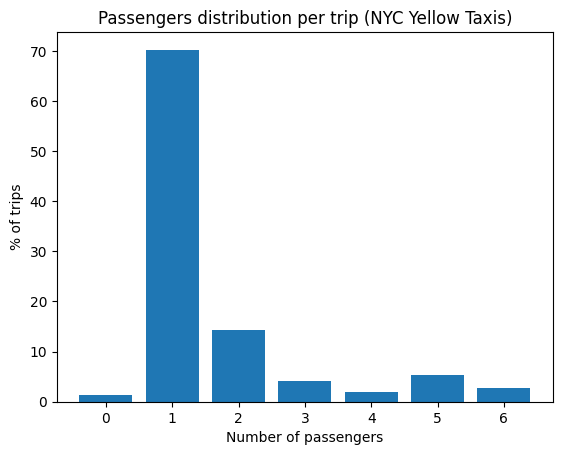

In [73]:
# We change the nulls for 0 to show it in the graph
plt.bar(passenger_dist.fill_null(0)["value"], passenger_dist["pct"])
plt.xlabel("Number of passengers")
plt.ylabel("% of trips")
plt.title("Passengers distribution per trip (NYC Yellow Taxis)")
plt.show()

Al analizar la distribución del número de pasajeros, observamos que la gran mayoría de los viajes se realizan con un solo pasajero, representando aproximadamente el 70% del total.

Los viajes con dos pasajeros son el segundo grupo más frecuente (alrededor del 14%), seguidos a distancia por los viajes con cinco pasajeros (5%) y tres pasajeros (4%).
Los trayectos con cuatro o seis pasajeros son menos comunes (entre el 2% y 3%), mientras que los registros nulos representan cerca del 1% de los datos.

En conjunto, la distribución confirma que la mayoría de los desplazamientos en taxi se realizan de forma individual, con una presencia mucho menor de viajes grupales.

In [57]:
lf_passenger = passenger_cleaned.select([
    pl.col("tpep_pickup_datetime"), pl.col("passenger_count")
])

passengers_stats = get_stats(lf=lf_passenger)

📆 Recording annual statistics:   0%|          | 0/14 [00:00<?, ?year/s]

  📊 Processing columns for 2011:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2012:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2013:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2014:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2015:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2016:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2017:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2018:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2019:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2020:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2021:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2022:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2023:   0%|          | 0/2 [00:00<?, ?col/s]

  📊 Processing columns for 2024:   0%|          | 0/2 [00:00<?, ?col/s]

✅ Statistics for every year recorded


In [70]:
stats_df = (
    build_stats_year(passengers_stats, ['passenger_count'])
    .collect(engine='streaming')
)
stats_df.drop(useless_cols)

count,null_count,mean,std,min,25%,50%,75%,max,n_values,year
i64,i64,f64,f64,str,str,str,str,str,i64,i32
176868080,2547009,1.675756,1.254581,"""1""","""1.0""","""1.0""","""2.0""","""6""",7,2011
171355659,1242289,1.68794,1.324335,"""1""","""1.0""","""1.0""","""2.0""","""6""",7,2012
171803259,4830,1.707387,1.37295,"""1""","""1.0""","""1.0""","""2.0""","""6""",7,2013
165435989,7990,1.695924,1.354737,"""1""","""1.0""","""1.0""","""2.0""","""6""",7,2014
146032289,40681,1.681309,1.333375,"""1""","""1.0""","""1.0""","""2.0""","""6""",7,2015
…,…,…,…,…,…,…,…,…,…,…
24627256,1279514,1.498686,1.103516,"""1""","""1.0""","""1.0""","""2.0""","""6""",7,2020
30864417,2145442,1.462405,1.020736,"""1""","""1.0""","""1.0""","""2.0""","""6""",7,2021
39640024,2118691,1.429577,0.951236,"""1""","""1.0""","""1.0""","""1.0""","""6""",7,2022


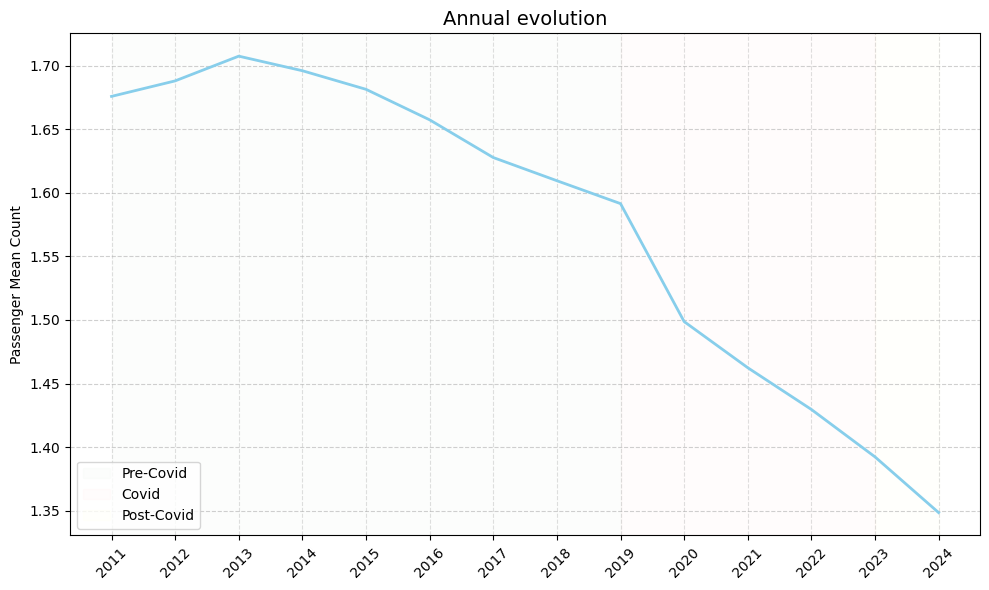

In [114]:
plt.figure(figsize=(10, 6))

# --- Áreas sombreadas por rangos de años ---
plt.axvspan(2011, 2019, color="green", alpha=0.01, label="Pre-Covid")
plt.axvspan(2019, 2023, color="red", alpha=0.01, label="Covid")
plt.axvspan(2023, 2024, color="yellow", alpha=0.01, label="Post-Covid")

plt.plot(stats_df["year"], stats_df["mean"], color="skyblue", linewidth=2)

plt.title("Annual evolution", fontsize=14)
plt.ylabel("Passenger Mean Count")

plt.xticks(stats_df["year"], rotation=45)

plt.grid(True, linestyle="--", alpha=0.6)

plt.gca().xaxis.grid(True, linestyle="--", alpha=0.4)

plt.legend()

plt.tight_layout()
plt.show()

A partir de 2013 se observa una **disminución progresiva en el número medio de pasajeros por viaje**, una tendencia que se acentúa notablemente entre 2019 y 2020, coincidiendo con el inicio de la pandemia de la COVID-19.

Desde 2020, la media se ha mantenido relativamente estable, lo que sugiere que el **patrón de uso del taxi en la ciudad se ha consolidado principalmente en viajes individuales**.

En conjunto, estos resultados refuerzan la idea de que el desplazamiento en taxi es, en su mayoría, una **actividad unipersonal**, incluso tras la recuperación posterior a la pandemia.

#### trip_distance